# Stellar Classification

**Author:** Esteban Duran

**Description:** The classification of cosmic entities is a fundamental problem
in astronomy. In this project we will be using machine learning techniques to
create a classification model that can reliably classify the cosmic entities of
galaxy, quasar, and star from the [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)
dataset taken by the [ Sloan Digital Sky Survey (SDSS)](https://www.sdss.org).
The dataset contains 100,000 observations where each observation consists of
17 feature columns and 1 class column. The algorithms we will be using include:

- Logistic Regression
- Support Vector Machine
- K-Nearest Neighbors (KNN)
- Decision Tree
- Random Forest
- Neural Network

I will be comparing these algorithms against each other and selecting the one
that ends up performing the best.

**Dataset:** [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

## Setup

In [2]:
# Import all the modules we will need
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastcore.all import *

import plotly.express as px

# import seaborn as sns

from numpy import random
from sklearn.model_selection import train_test_split

import torch, numpy as np, pandas as pd

# Set print options to conform to the notebook width
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option("display.width", 140)

# Set the seaborn theme
# sns.set_theme(style="whitegrid")

# ! We need this to get some of the training output to work. This will be fixed
# in a future release of Jupyter for VS Code.
# https://github.com/microsoft/vscode-jupyter/pull/13442#issuecomment-1541584881
from IPython.display import clear_output, DisplayHandle


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch

random.seed(42)
torch.manual_seed(42)

## Load Data

Lets start by first downloading our dataset from Kaggle.

In [3]:
dataset_name = "fedesoriano/stellar-classification-dataset-sdss17"
dataset_path = URLs.path(dataset_name)

dataset_path

Path('/root/.fastai/archive/stellar-classification-dataset-sdss17')

In [4]:
Path.BASE_PATH = dataset_path

In [5]:
# Download the dataset to a hidden folder and extract it from kaggle
if not dataset_path.exists() or not any(Path(dataset_path).iterdir()):
    import kaggle

    dataset_path.mkdir(parents=True, exist_ok=True)
    kaggle.api.dataset_download_cli(dataset_name, path=dataset_path, unzip=True)

dataset_path.ls()

(#1) [Path('star_classification.csv')]

Now that we have downloaded our data we can load it into a Pandas DataFrame.

In [6]:
stellar_df = pd.read_csv(dataset_path / "star_classification.csv", low_memory=False)
stellar_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## Data Analysis

Lets now dive into some data analysis and take a look at what we are working with.

In [7]:
stellar_df.shape

(100000, 18)

We can see that we have 100,000 observations with 18 columns where 17 of the
columns are feature columns and the 18th is the label or target.

Now lets see if we have any null values in our dataset that we need to substitute.

In [8]:
stellar_df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

We have none! That's great news!

In [9]:
stellar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

We can see from this summary that our class is actually an object type. We need
it to be some numerical value.

In [10]:
stellar_df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


We can also see that some of the values of our features are very very large. Take
`alpha` with a max value of 359.99. We might need to normalize those later on.

Lets now take a closer look at that `class` column.

In [12]:
# df['Embarked'] = pd.Categorical(df.Embarked)

stellar_df["class"].nunique()

3

In [13]:
stellar_df["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

We can notice a class imbalance with significantly more galaxy classes than stars
and even more than quasars. We'll need to fix this with some resampling later on.

Lets now proceed to visualize some of our features.

In [17]:
px.histogram(
    stellar_df,
    title="Number of Cosmic Entities",
    x="class",
    color="class",
)

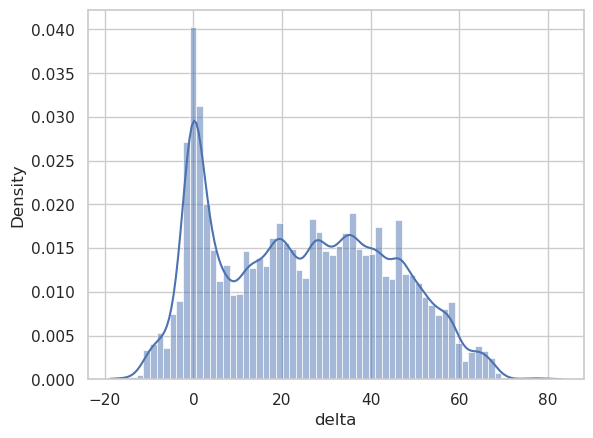

In [39]:
# Lets see the distribution plot which depicts the variation in the data
# distribution
sns.histplot(stellar_df.delta, kde=True, stat="density")
plt.show()

## Data Preprocessing

### Encoding

### Feature Selection

### Resampling

## Dataset Split

## Classification

## Results